In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


from imblearn.over_sampling import SMOTE
from sklearn import utils

from google.colab import drive

In [ ]:
drive.mount('/content/drive', force_remount=True)

In [3]:
path = '/content/drive/My Drive/Datasets/'

In [4]:
df = pd.read_csv(path + 'Data_for_UCI_named.csv')

In [5]:
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [6]:
df.isna().sum()

tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df['stabf'].value_counts()

unstable    6380
stable      3620
Name: stabf, dtype: int64

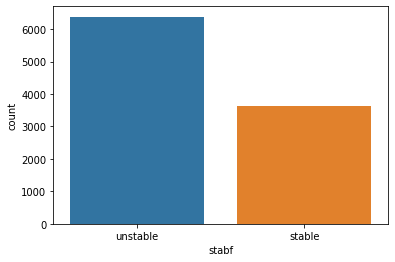

In [9]:
sns.countplot(df.stabf)

In [10]:
#drop stab
df = df.drop('stab', axis=1).copy()

In [11]:
#split data 80-20

x_data = df.drop('stabf', axis=1)
y_data = df.stabf

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=1)

In [12]:
#scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train, y_train)
x_test_scaled = scaler.transform(x_test)

In [15]:
#train a random forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1)

rf.fit(x_train_scaled, y_train)

rf_preds = rf.predict(x_test_scaled) 

In [16]:
from sklearn.metrics import accuracy_score

rf_accuracy_score = accuracy_score(y_true=y_test, y_pred=rf_preds)
rf_accuracy_score

0.929

In [17]:
#train an xgboost classifier
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=1)
xgb.fit(x_train_scaled, y_train)

xgb_preds = xgb.predict(x_test_scaled)

xgb_accuracy = accuracy_score(y_true=y_test, y_pred=xgb_preds)
xgb_accuracy

0.9195

In [24]:
#train an LGBM
import lightgbm

lgb_train_data=lgb.Dataset(x_train_scaled,label=y_train)

param = {'objective':'binary'}
param['metric'] = 'accuracy'

lgbm=lgb.train(params = param, train_set = lgb_train_data)

lgb_preds = lgbm.predict(x_test_scaled)

lgb_accuracy = accuracy_score(y_true=y_test, y_pred=lgb_preds)

ValueError: ignored

In [27]:
#build an ET model
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV

etc = ExtraTreesClassifier(random_state=1)

n_estimators = [50, 100, 300, 500, 1000]
min_samples_split = [2, 3, 5, 7, 9]
min_samples_leaf = [1, 2, 4, 6, 8]
max_features = ['auto', 'sqrt', 'log2', None]

hyperparameter_grid = {'n_estimators': n_estimators,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

randomizedsearch = RandomizedSearchCV(etc, hyperparameter_grid, random_state=1, n_iter=10, cv=5, scoring = 'accuracy', n_jobs = -1, verbose = 1)

best_model = randomizedsearch.fit(x_train_scaled, y_train)

best_model.best_estimator_.get_params()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.5min finished


{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [28]:
#build etc w/o hyperparameter tuning
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier(random_state=1)

etc.fit(x_train_scaled, y_train)

naive_etc_preds = etc.predict(x_test_scaled)

naive_etc_accuracy = accuracy_score(y_true=y_test, y_pred=naive_etc_preds)

naive_etc_accuracy

0.928

In [29]:
#build etc with hyperparameter tuning
from sklearn.ensemble import ExtraTreesClassifier

optimized_etc = ExtraTreesClassifier(random_state=1, n_estimators= 1000, min_samples_leaf= 8, min_samples_split= 2, max_features=None)

optimized_etc.fit(x_train_scaled, y_train)

optimized_etc_preds = optimized_etc.predict(x_test_scaled)

optimized_etc_accuracy = accuracy_score(y_true=y_test, y_pred=optimized_etc_preds)

optimized_etc_accuracy

0.927

In [39]:
# Calculate feature importances
import numpy as np

importances = optimized_etc.feature_importances_
importances

array([0.13723975, 0.1405075 , 0.13468029, 0.13541676, 0.00368342,
       0.00533686, 0.00542927, 0.00496249, 0.10256244, 0.10757765,
       0.11306268, 0.10954089])

In [31]:
feats = x_train.columns.values.tolist()
features = [feats[i] for i in indices]

'tau1'

In [37]:
np.argmax(importances)

1

In [38]:
np.argmin(importances)

4

In [40]:
x_train.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
2694,6.255995,2.542401,7.024714,9.476518,3.529888,-1.224881,-0.688228,-1.616780,0.568221,0.618403,0.685739,0.660088
5140,5.070581,5.490253,8.075688,0.761075,4.220888,-1.280596,-1.902185,-1.038107,0.443515,0.097244,0.916955,0.129254
2568,1.220072,8.804028,3.874283,8.433949,3.614027,-1.039236,-0.953566,-1.621224,0.908353,0.923594,0.238881,0.660156
3671,7.498402,6.697603,8.798626,2.126236,3.134585,-1.581906,-0.589386,-0.963293,0.260826,0.899003,0.964752,0.600598
7427,7.074006,1.337511,6.100756,7.759156,2.526922,-0.922540,-0.632600,-0.971782,0.984580,0.716082,0.836928,0.165162
